# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

### Gather observables

In [6]:
def f_gather_data(fname):
    
    # Get Plaquette values
    cmd="grep 'Plaq' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr1=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), 
      np.float64(i.split(' ')[-1]),
      np.float64(i.split(': ')[2].split(' s')[0])] 
     for i in op])
    
    # Gather Polykov loop values
    cmd="grep 'Polyakov' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr2=np.array([complex(np.float64(i.split(' ')[-1][1:-1].split(',')[0]),
             np.float64(i.split(' ')[-1][1:-1].split(',')[1])) 
     for i in op ])
    
    ## Total time
    cmd="grep 'Total time for trajectory' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr3=[np.float32(i.split(': ')[-1]) for i in op]
    
    
    lgth=min(len(arr1),len(arr2),len(arr3))
#     print(lgth)

    ## Metropolis values
    cmd="grep 'Metropolis_test' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
    skip=lgth-len(arr_temp)
#     print("skip",skip)
    arr_skip=[np.nan for i in range(skip)]
    arr4=np.array(arr_skip+arr_temp)

    
    ## Create dataframe
    cols=['iter','Plaquette','Polyakov','Traj_time','Accept','Plaq_epoch']
    df=pd.DataFrame(columns=cols)

    df['Plaquette']=arr1[:,1]
    df['Plaq_epoch']=arr1[:,2]
    df['iter']=arr1[:,0].astype(int)
    df['Polyakov']=arr2
    df['Traj_time']=arr3
    df['Accept']=arr4

    return df


def f_get_summary(df):
    drop_idx=20

    y=df.Plaquette.values[drop_idx:]
    plaq=gv.dataset.avg_data(y)

    y=np.abs(df.Polyakov.values[drop_idx:])
    polyakov=gv.dataset.avg_data(y)

    y=df.Traj_time.values[drop_idx:]
    traj_time=gv.dataset.avg_data(y)
    
    y=df['Accept'].dropna().values
    Act=y[y==1].shape[0]
    Rjt=y[y==0].shape[0]
    accpt=Act* 100 /(Act+Rjt)

    return plaq, polyakov, accpt, traj_time


In [7]:
dict_list=[]

df_combined=pd.DataFrame([])
df_summary=pd.DataFrame([])

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/'

flist=[]
for fldr in glob.glob(top_dir+'run_L*'): 
    fname=fldr+'/HSDM.out'
    
    if not os.path.isfile(fname): continue
        
    flist.append(fname)
    
    
    try: 
        df=f_gather_data(fname)
        beta = float(fname.split('/')[-2].split('_')[-2].split('-')[-1])
        mf   = float(fname.split('/')[-2].split('_')[-1].split('-')[-1])
        dict1={'beta':beta, 'mf':mf, 'df':df}
    #     print(dict1)
    
        dict_list.append(dict1)
        # Get summary data
        plaq,polyakov,accpt,traj_time=f_get_summary(df)
        dict1={'beta':beta, 'mf':mf, 'plaq':plaq,'polyakov':polyakov,'acceptance':accpt, 'traj_time':traj_time}

        df_summary=pd.concat([df_summary,pd.DataFrame(dict1,index=[df_summary.shape[0]+1])])    
    
    except Exception as e: 
        print(fname)
        print(e)
    

df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)

In [8]:
df_summary

,beta,mf,plaq,polyakov,acceptance,traj_time
0,8.0,0.6443,0.289102(38),0.00333(12),98.5,14.7151(25)
1,9.0,0.4443,0.3452(12),0.00390(37),97.0,15.8405(23)
2,9.0,0.6443,0.3450(12),0.00401(36),98.0,14.5229(43)
3,9.0,0.8443,0.3448(12),0.00396(36),98.5,13.8695(25)
4,10.0,0.6443,0.4287(13),0.00495(56),93.5,14.5397(30)
5,11.0,0.2443,0.581219(38),0.03059(52),97.0,20.0944(47)
6,11.0,0.4443,0.58091(40),0.03272(75),96.5,15.8865(20)
7,11.0,0.6443,0.57966(40),0.03303(69),96.5,14.1480(17)
8,11.0,0.8443,0.57890(40),0.03276(72),97.5,13.3651(26)
9,11.0,1.0443,0.57833(40),0.02871(75),96.5,13.1481(26)


## Summary plots

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [9]:
mf_list   = np.sort(np.unique(df_summary.mf.values))
beta_list = np.sort(np.unique(df_summary.beta.values))

<IPython.core.display.Javascript object>


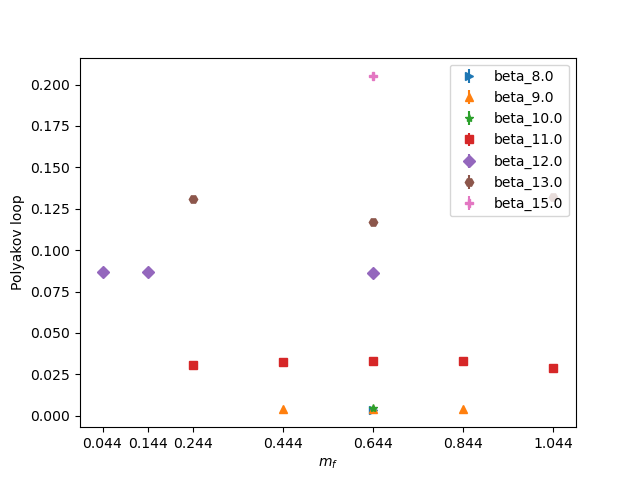

In [12]:
plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
plt.xticks(mf_list)
plt.legend(loc='best')
plt.ylabel('Polyakov loop',rotation='vertical')
plt.savefig('Ploop_vs_mf.pdf')

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


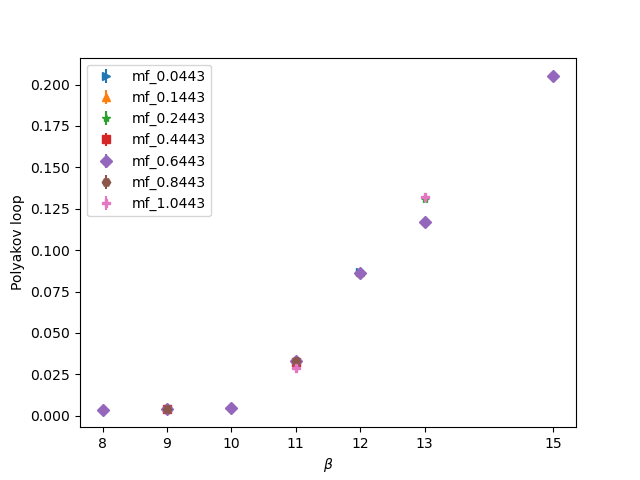

In [11]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(beta_list)
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
plt.savefig('Ploop_vs_beta.pdf')

## Individual plots

### Plot Plaquette

In [ ]:
plt.figure()

for i,marker in zip(dict_list,itertools.cycle('>^*sDHPdpx_')):

    df=i['df']
    label=str(i['beta'])+'_'+str(i['mf'])
    print(label)
    x=df.iter.values
    y=df.Plaquette.values
    # y=df.Traj_time.values

    plt.plot(x,y,linestyle='',label=label, marker=marker)

plt.legend(loc='best')
plt.ylabel('Plaquette')
plt.show()

### Plot Polyakov loop

In [ ]:
plt.figure()

for i,marker in zip(dict_list,itertools.cycle('>^*sDHPdpx_')):

    df=i['df']
    label=str(i['beta'])+'_'+str(i['mf'])
    print(label)
    x=df.iter.values
    y=np.abs(df.Polyakov.values)
    # y=df.Traj_time.values

    plt.plot(x,y,linestyle='',label=label, marker=marker)
    
plt.legend(loc='best')
plt.ylabel('Polyakov')
plt.show()

In [ ]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


In [ ]:
fig=plt.figure()

for i,marker in zip(dict_list,itertools.cycle('>^*sDHPdpx_')):
    df=i['df']
    label=i['beta']+'_'+i['mf']
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

In [40]:
# 1.0/(2*(m+4))
1.0/(2*0.12) - 4 

0.16666666666666696

5.0